In [2]:
# Boilerplate imports + paths

from pathlib import Path
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pyvis.network import Network
from cdlib import algorithms

# Project root
PROJECT_ROOT = Path(r"C:\Users\moein\20th-century")
REL_PATH = PROJECT_ROOT / "data" / "reference" / "country_relationships.csv"
OUT_HTML_DIR = PROJECT_ROOT / "reports" / "html"
OUT_FIG_DIR  = PROJECT_ROOT / "reports" / "figures"

OUT_HTML_DIR.mkdir(parents=True, exist_ok=True)
OUT_FIG_DIR.mkdir(parents=True, exist_ok=True)

# Load the relationships
df_rel = pd.read_csv(REL_PATH)
df_rel.head()

,source,target,value
0,Albania,Bulgaria,1
1,Albania,Greece,1
2,Albania,Ussr,1
3,Algeria,Italy,1
4,Algeria,Morocco,1


In [5]:
# Create a NetworkX graph from the dataframe
# Ensure types are strings (nodes) and numeric (weights)
df_rel['source'] = df_rel['source'].astype(str)
df_rel['target'] = df_rel['target'].astype(str)
df_rel['value']  = pd.to_numeric(df_rel['value'], errors='coerce').fillna(1).astype(int)

# Build an undirected, weighted graph
G = nx.from_pandas_edgelist(
    df_rel,
    source="source",
    target="target",
    edge_attr="value",
    create_using=nx.Graph()
)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

degrees = dict(G.degree())
print(f"Average degree: {sum(degrees.values())/len(degrees):.2f}")

Graph has 56 nodes and 110 edges
Average degree: 3.93


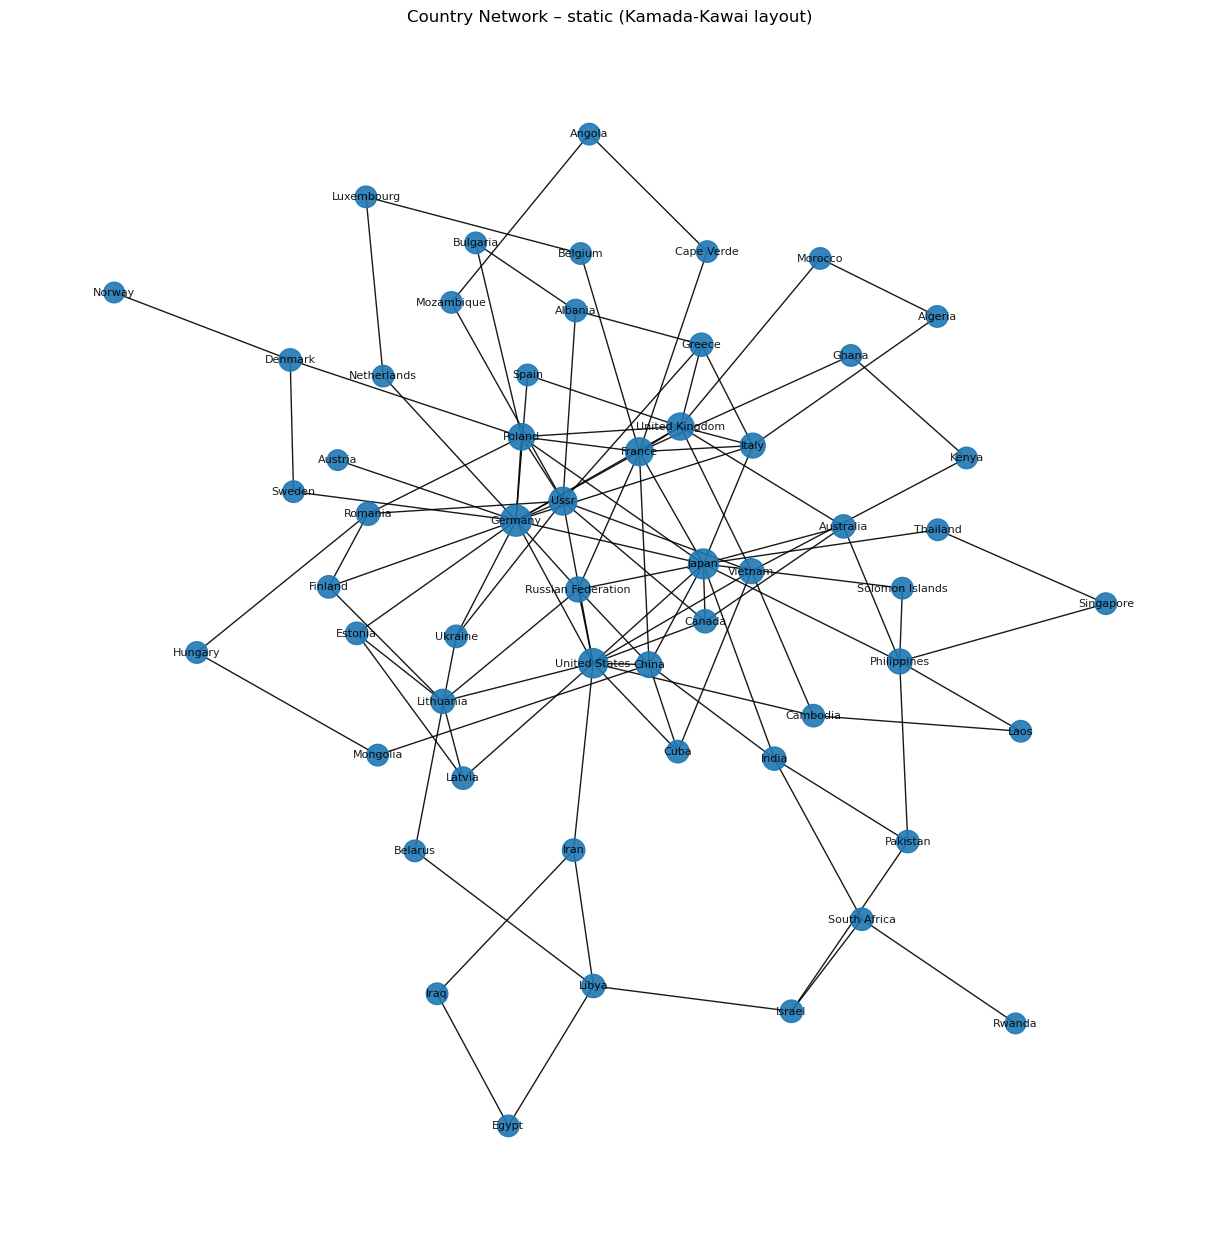

In [7]:
# Make a static NetworkX + Matplotlib plot
plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)

# Node sizes ~ degree; Edge widths ~ weight
deg = dict(G.degree())
node_sizes = [200 + 20*deg[n] for n in G.nodes()]
edge_widths = [0.5 + 0.5*G[u][v]['value'] for u,v in G.edges()]

nx.draw(
    G, pos,
    with_labels=True,
    node_size=node_sizes,
    width=edge_widths,
    font_size=8,
    alpha=0.9
)

THRESH = 3  # e.g., keep edges mentioned ≥3 times
H = nx.Graph(((u, v, d) for u, v, d in G.edges(data=True) if d['value'] >= THRESH))

plt.title("Country Network – static (Kamada-Kawai layout)")
plt.tight_layout()
plt.savefig(OUT_FIG_DIR / "countries_static.png", dpi=200)
plt.show()

In [8]:
# Build an interactive graph with Pyvis and save HTML
net = Network(notebook=True, width="1200px", height="800px", bgcolor="#111111", font_color="white")
# Tweak physics so it stabilizes nicely
net.barnes_hut(gravity=-20000, central_gravity=0.3, spring_length=150, spring_strength=0.01)

# Optional: scale node size by degree
deg = dict(G.degree())
nx.set_node_attributes(G, deg, "size")  # pyvis will use this as node size
# pyvis also reads 'value' on edges to set widths

net.from_nx(G)
net.show_buttons(filter_=["physics", "nodes", "edges"])
out_html = OUT_HTML_DIR / "countries_network.html"
net.show(out_html.as_posix())
out_html

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


WindowsPath('C:/Users/moein/20th-century/reports/html/countries_network.html')

In [9]:
# Detect communities with Leiden (on weighted graph)
# Leiden can use weights if present under the given attribute name
coms = algorithms.leiden(G, weights="value")   # runs on G
node_to_com = coms.to_node_community_map()     # {'France':[0], 'UK':[1], ...}

# Convert to {node: group_id}
group_map = {node: groups[0] for node, groups in node_to_com.items()}
nx.set_node_attributes(G, group_map, "group")

In [10]:
# Visualize communities in a new interactive graph + write observations
com_net = Network(notebook=True, width="1200px", height="800px", bgcolor="#111111", font_color="white")
com_net.barnes_hut(gravity=-20000, central_gravity=0.3, spring_length=150, spring_strength=0.01)
com_net.from_nx(G)  # pyvis uses node attribute 'group' to color by community

com_net.show_buttons(filter_=["physics", "nodes", "edges"])
out_html2 = OUT_HTML_DIR / "countries_communities_leiden.html"
com_net.show(out_html2.as_posix())
out_html2

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


WindowsPath('C:/Users/moein/20th-century/reports/html/countries_communities_leiden.html')

### Community Detection Visualization and Observations

The Leiden algorithm partitions the countries into distinct communities, and the resulting network visualization highlights these clusters clearly.

**Observations:**
- The partition largely aligns with historical and geopolitical blocs. For example, the **US, UK, France, and allies** form one cluster, while the **USSR and Eastern European states** cluster together, reflecting the Cold War divide.  
- Some groups mix regional proximity with ideological alignment (e.g., Vietnam, Cuba, and the USSR are linked, while Western Europe is strongly tied together).  
- Countries like **Germany** act as a hub with connections bridging multiple clusters, consistent with its central role in 20th-century geopolitics.  
- Smaller regional clusters appear, such as **North African states** or **Asian Pacific connections**, showing how colonial and post-colonial ties shaped global relationships.  

**Conclusion:**  
The communities detected by the Leiden algorithm make sense in the context of history, especially the Cold War and regional alliances. The visualization highlights how political ideology, geography, and historical events influenced the structure of international connections. It also reveals bridging countries that had significant roles in connecting otherwise distinct communities.


In [11]:
# Centrality metrics: degree, closeness, betweenness (+ charts)
# Weighted closeness/betweenness: use length = 1/weight so strong ties are "short"
# Build a weighted copy with 'length'
H = G.copy()
for u, v, d in H.edges(data=True):
    w = d.get('value', 1)
    d['length'] = 1.0 / max(w, 1)

# Metrics
deg_c  = nx.degree_centrality(G)  # unweighted degree centrality
close_c = nx.closeness_centrality(H, distance='length')
between_c = nx.betweenness_centrality(H, weight='length', normalized=True)

# Combine to a tidy DataFrame
metrics_df = (
    pd.DataFrame({
        'node': list(G.nodes()),
        'degree_centrality': [deg_c[n] for n in G.nodes()],
        'closeness_centrality': [close_c[n] for n in G.nodes()],
        'betweenness_centrality': [between_c[n] for n in G.nodes()]
    })
    .sort_values('degree_centrality', ascending=False)
    .reset_index(drop=True)
)
metrics_df.head(10)

,node,degree_centrality,closeness_centrality,betweenness_centrality
0,Germany,0.272727,0.491071,0.267017
1,Japan,0.236364,0.491071,0.256010
2,United States,0.218182,0.466102,0.217488
3,Ussr,0.181818,0.429688,0.136590
4,France,0.181818,0.447154,0.150005
5,United Kingdom,0.163636,0.419847,0.074505
6,Poland,0.145455,0.429688,0.122186
7,China,0.127273,0.413534,0.076053
8,Vietnam,0.109091,0.390071,0.049690
9,Russian Federation,0.109091,0.419847,0.017141


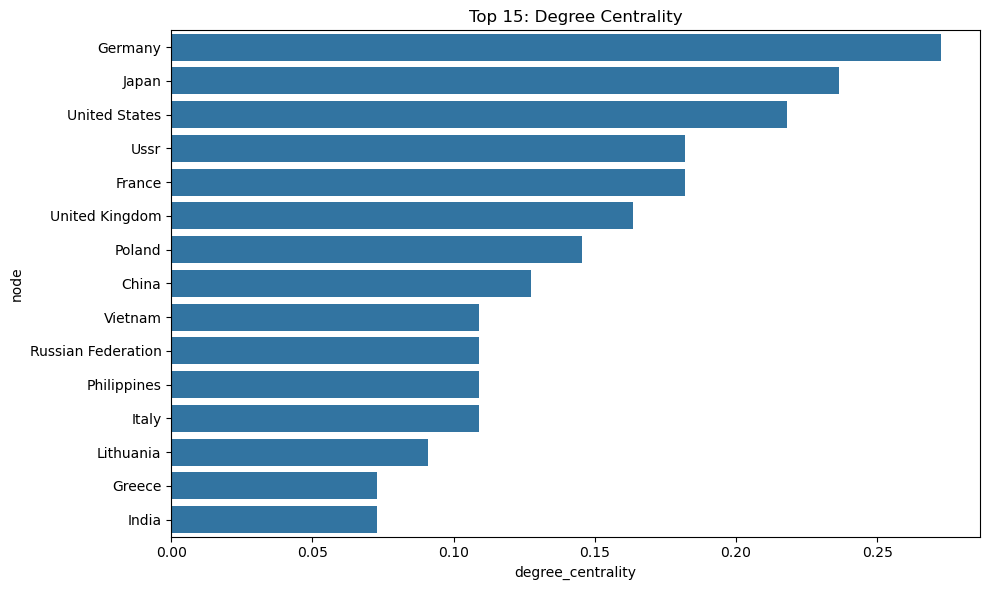

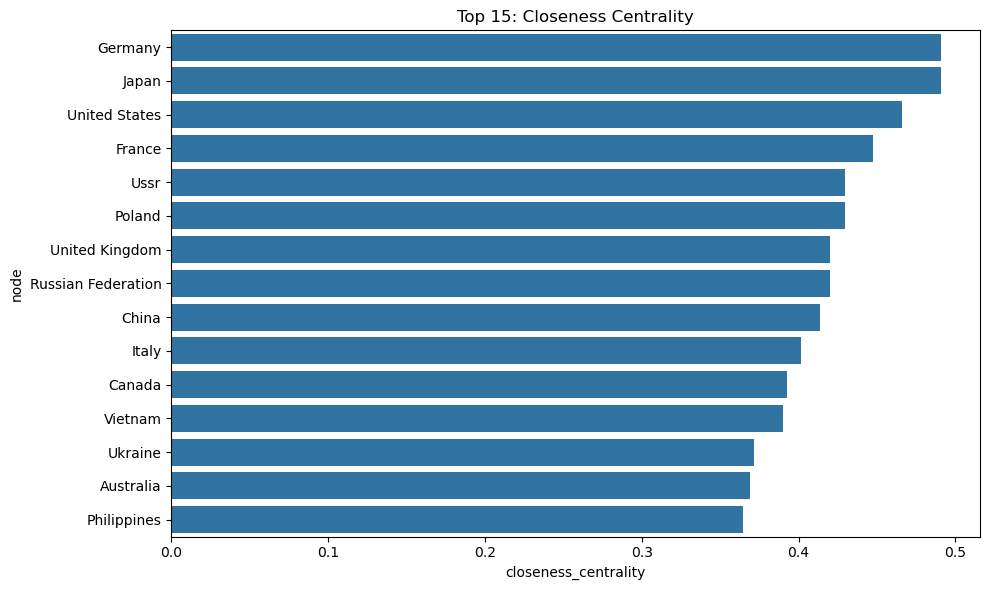

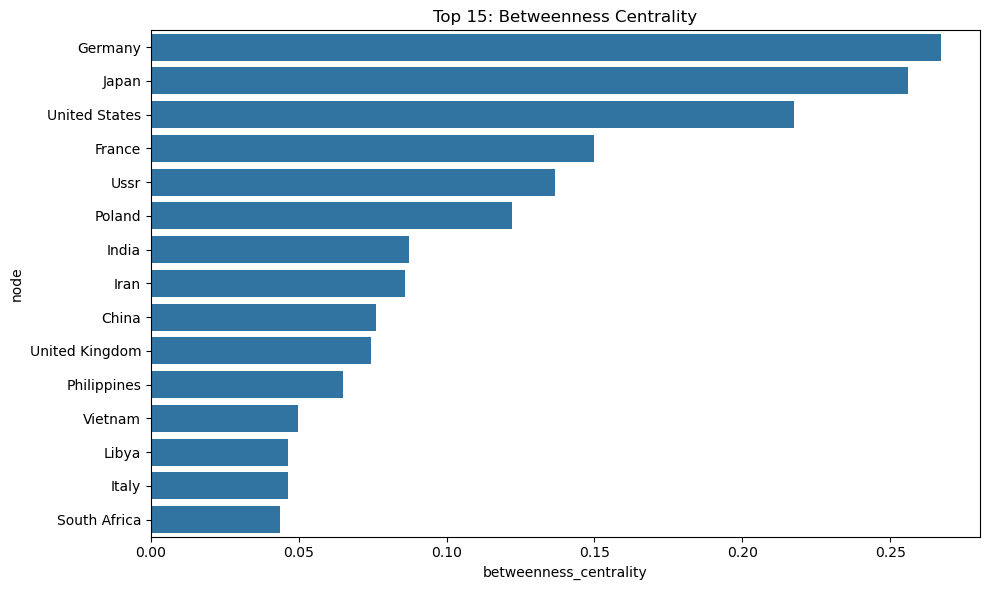

In [12]:
# Plot top-15 bars for each metric
def plot_top(metric, topn=15):
    tmp = metrics_df.sort_values(metric, ascending=False).head(topn)
    plt.figure(figsize=(10,6))
    sns.barplot(data=tmp, x=metric, y='node')
    plt.title(f"Top {topn}: {metric.replace('_',' ').title()}")
    plt.tight_layout()
    plt.savefig(OUT_FIG_DIR / f"top_{topn}_{metric}.png", dpi=200)
    plt.show()

plot_top('degree_centrality', 15)
plot_top('closeness_centrality', 15)
plot_top('betweenness_centrality', 15)

### Centrality Measures Observations

The three centrality measures—**degree**, **closeness**, and **betweenness**—provide complementary insights into the role of countries in 20th-century global networks:

- **Degree Centrality**:  
  Germany, Japan, and the United States appear as the most connected nodes, reflecting their extensive involvement in international events. The USSR, France, and the UK also rank highly, which matches their influence during the world wars and post-war alliances.

- **Closeness Centrality**:  
  Germany and Japan again dominate, followed closely by the United States and France. Their high closeness values suggest they were well-positioned to interact efficiently with many other countries, reinforcing their central roles in both conflict and diplomacy.

- **Betweenness Centrality**:  
  Germany has the highest score, followed by Japan and the United States. This indicates their pivotal role as "bridges" in the network—countries through which many geopolitical interactions passed. France and the USSR also score highly, consistent with their roles in shaping alliances and conflicts. Interestingly, India and Iran also appear, showing their importance as connectors between regions.

**Conclusion**:  
All three measures highlight Germany, Japan, and the United States as the most central actors in 20th-century geopolitics. The results align with historical reality: Germany as a driving force in both World Wars, Japan’s role in Asia-Pacific conflicts, and the United States’ rise as a global superpower. The presence of other nations such as India, Iran, and the Philippines in betweenness centrality reflects their strategic positions as intermediaries in global relations.